In [2]:
# !pip install umap-learn ipdb
# !pip install jupyter-dash
# !pip install ipympl
# !jupyter nbextension enable --py --sys-prefix ipympl
## RUN THIS AS A NOTEBOOK! help-->Launch Classic Notebook

# unused strategy: https://dash.plotly.com/dash-core-components/tooltip

In [3]:
%matplotlib inline
# %matplotlib widget
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import os
from src.simple_utils import load_pickle
from src.data_utils import cifar10_label_names, get_dataset
from os.path import join
from cifarclass import cifar100_classes
from scipy.interpolate import interp1d

import seaborn as sns
import colorcet as cc
from ipdb import set_trace
import pandas as pd
import umap

label_mapping=cifar100_classes
classes = list(label_mapping.values())

alpha =0.2 
markersize=12

indices = np.random.default_rng(2).choice(np.arange(10000), size=10)

In [4]:
name = "CIFAR100_test"
train_set = "CIFAR100_train"

print("loading data")
grouped = load_pickle('../processed/cifar100/resnets/group2.pkl')
groups = list(grouped[name].keys())
group = groups[0]
print(groups)
print("done")

print("loading dataset")
dataset = get_dataset('data', name)
ytest = np.array(dataset.targets)
print("done")

loading data
['Resnet18-pretrained', 'Densenet121-pretrained', 'Resnet18', 'Densenet121']
done
loading dataset
Files already downloaded and verified
done


In [14]:
# preprocessing: compute soft-accuracies
def probs_to_softacc(probs):
    return np.array([probs[i, yi, :] for i, yi in enumerate(ytest)]).mean(0)

softacc = probs_to_softacc(grouped[name]['Resnet18']['probs'])

In [15]:
def cut_labels(y, labels, k=8):
    good = np.argpartition(np.sum(y, axis=1), -k)[-k:]
    bad = set(range(100)).difference(set(list(good)))
    for i in bad:
        labels[i] = '_nolegend_'
    return labels

def stackplot(index, types = ["probs","freqs"], plot_group = "Resnet18"):
    dct = grouped[name][plot_group]
    print("index %d" % index)
    img, label = dataset.__getitem__(index)
    img = np.array(img)
    col = sns.color_palette(cc.glasbey, n_colors=25)

    for t in types:
        print(t)
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
        y = dct[t][index].copy() # probs/freqs
        
        ind = np.argsort(y[:,-1])[::-1] # sort labels according to their final probabilities
        #set_trace()
        print(f"Top 5 are {ind[:5]}")
        print(f"Prediction is {classes[ind[0]]}")
        y = y[ind]
        labels = [classes[ind[i]] for i in range(len(classes))]
        new_label = list(ind).index(label)
        
        # swap in the true-label as the first label in list (and in y)
        labels[0], labels[new_label] = labels[new_label], labels[0]
        y[[0,new_label]] = y[[new_label,0]]
        
        #truth = classes[label]
        labels = cut_labels(y, labels)
        #labels[0] = truth
        

            
        if t=="probs":
            xx = probs_to_softacc(dct["probs"])
            ax1.set_xlabel("Soft-Test acc on %s" % name, fontsize=16)
            ax1.set_ylabel("Softmax probabilities", fontsize=16)
        
        else:
            xx = dct["x"]
            ax1.set_xlabel("Test acc on %s" % name, fontsize=16)
            ax1.set_ylabel("Frequency of predictions", fontsize=16)
            
        
        ax1.stackplot(xx, y, labels=labels, colors = col)
        ax1.set_title(
            "Train %s, architecture %s" % (train_set, plot_group),
            fontsize=20,
        )

        ax1.legend(loc="best")
        ax2.imshow(img, interpolation="nearest")
        ax2.set_title("Index %d from %s, class: %s" % (index, name, classes[label]), fontsize=20)
        plt.show()

index 8375
probs
Top 5 are [11 35  2 32 98]
Prediction is boy


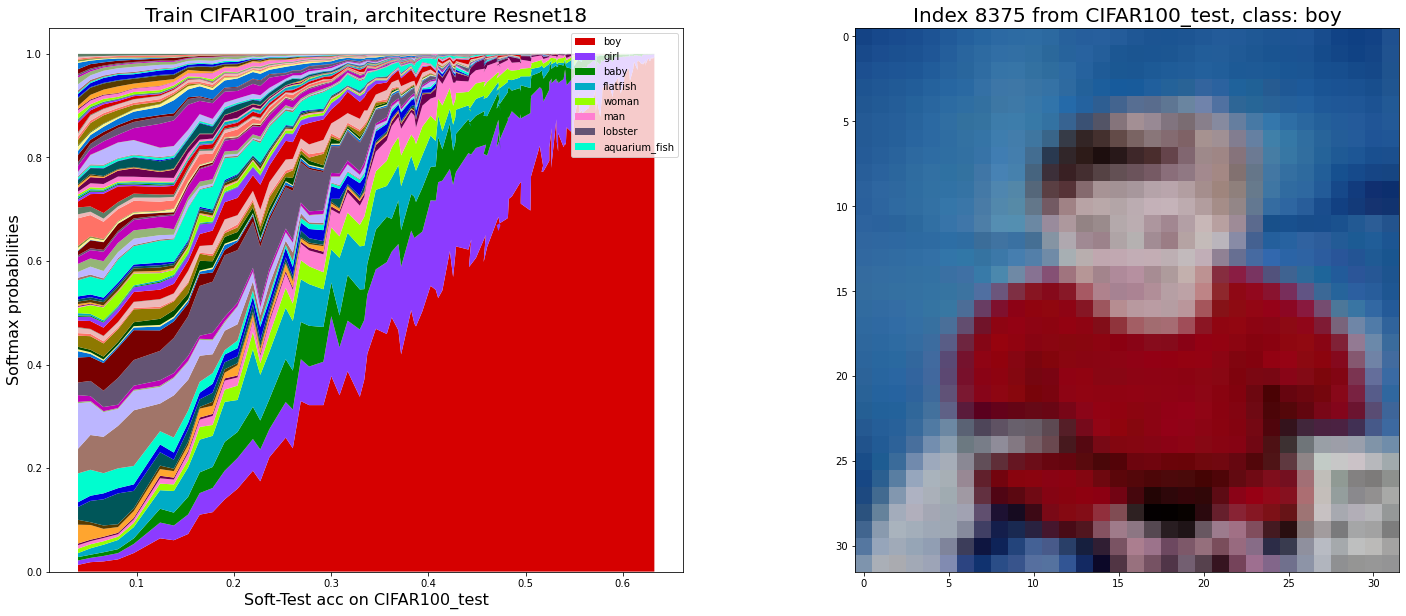

index 2616
probs
Top 5 are [75 51 74 66 78]
Prediction is skunk


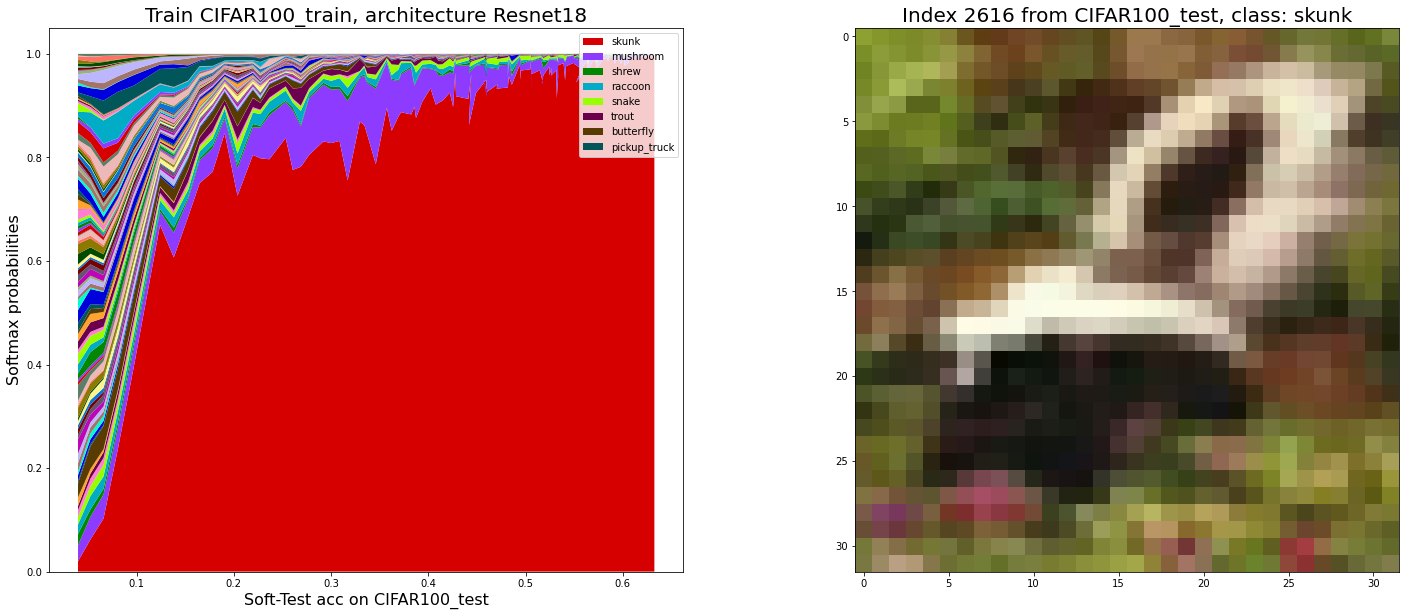

index 1093
probs
Top 5 are [93 67  6 73 29]
Prediction is turtle


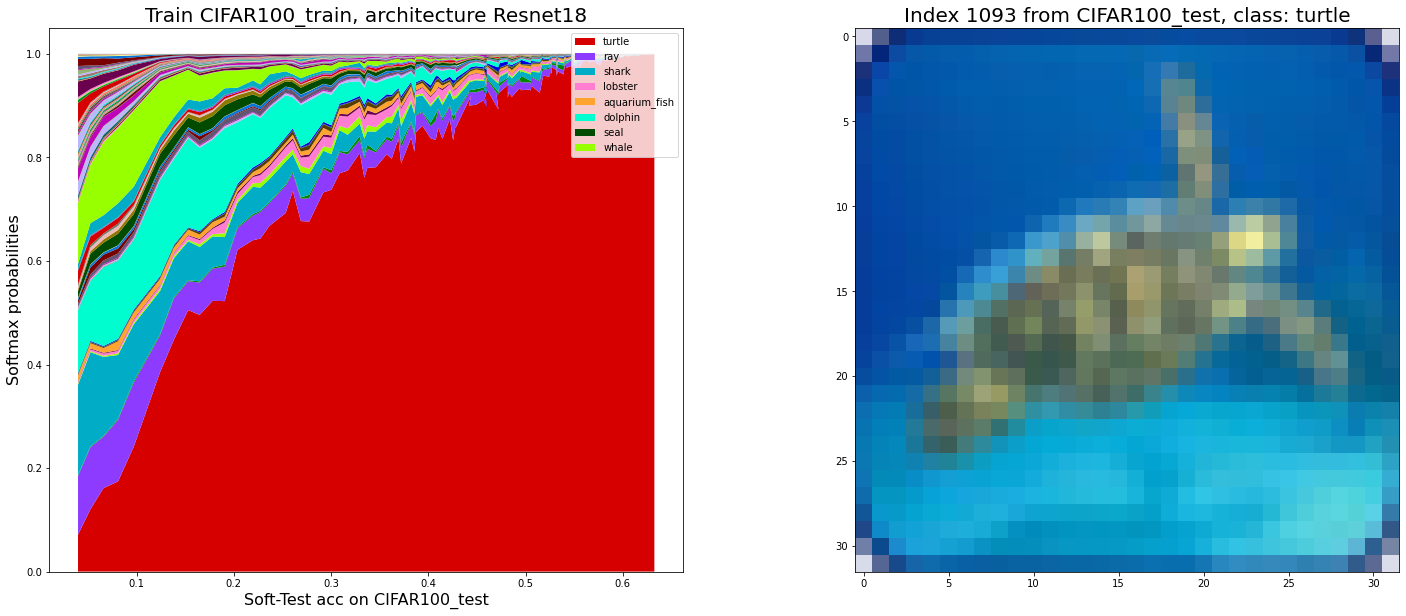

index 2984
probs
Top 5 are [65 66 32 64 93]
Prediction is rabbit


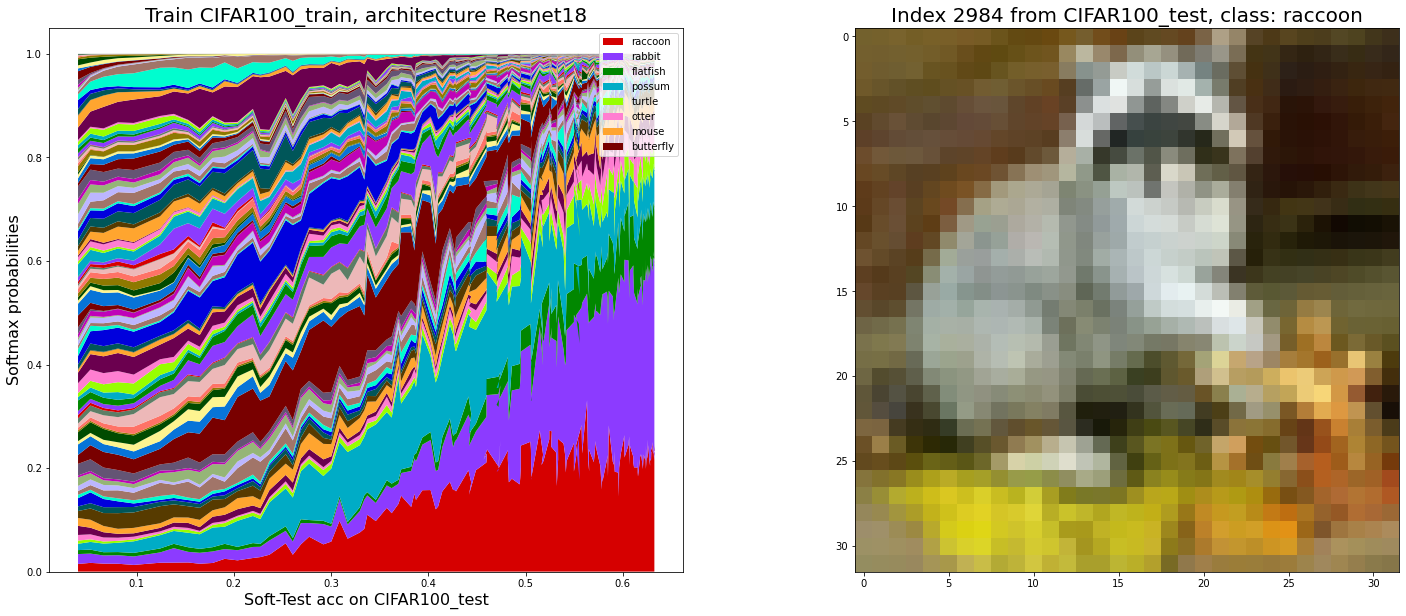

index 4138
probs
Top 5 are [65 38 55 27 85]
Prediction is rabbit


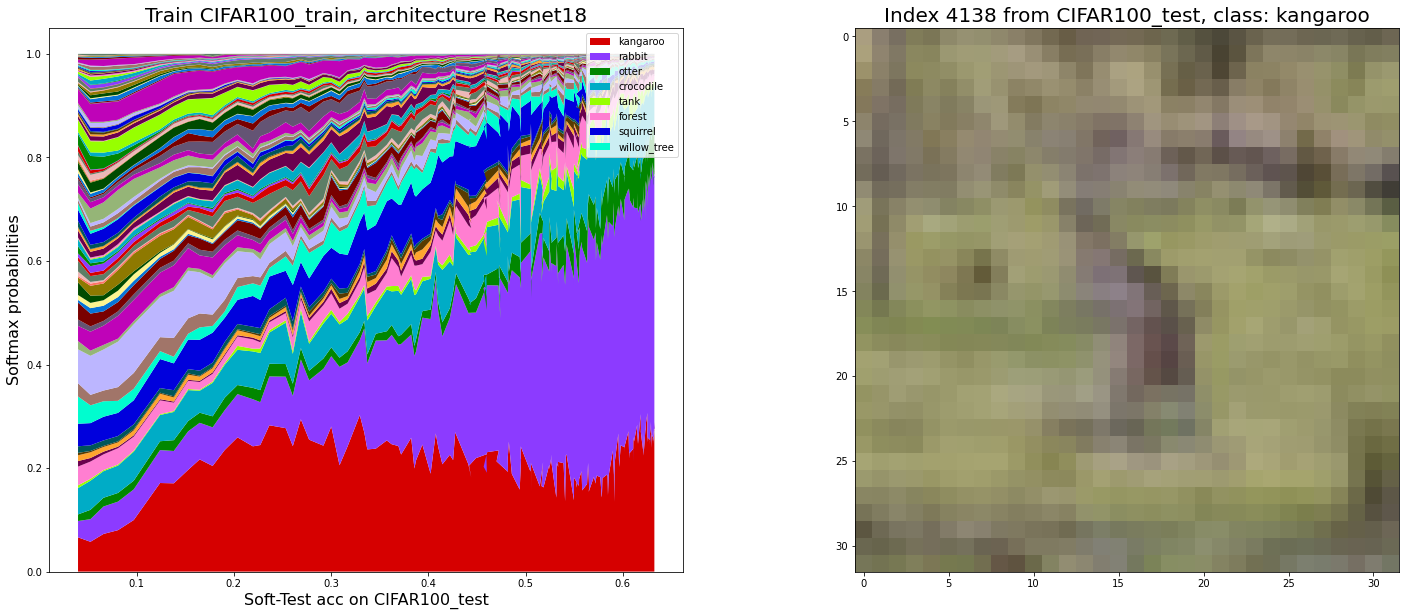

index 8142
probs
Top 5 are [44 18 39  6 78]
Prediction is lizard


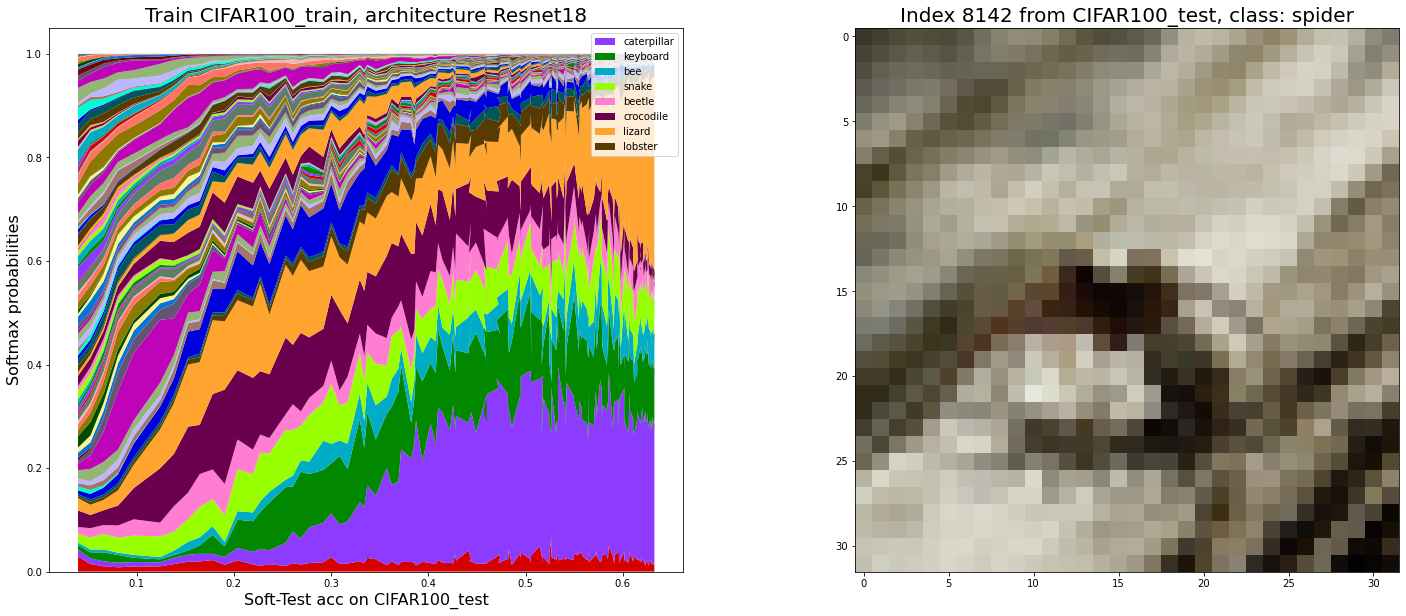

index 4512
probs
Top 5 are [21 46 98  3 72]
Prediction is chimpanzee


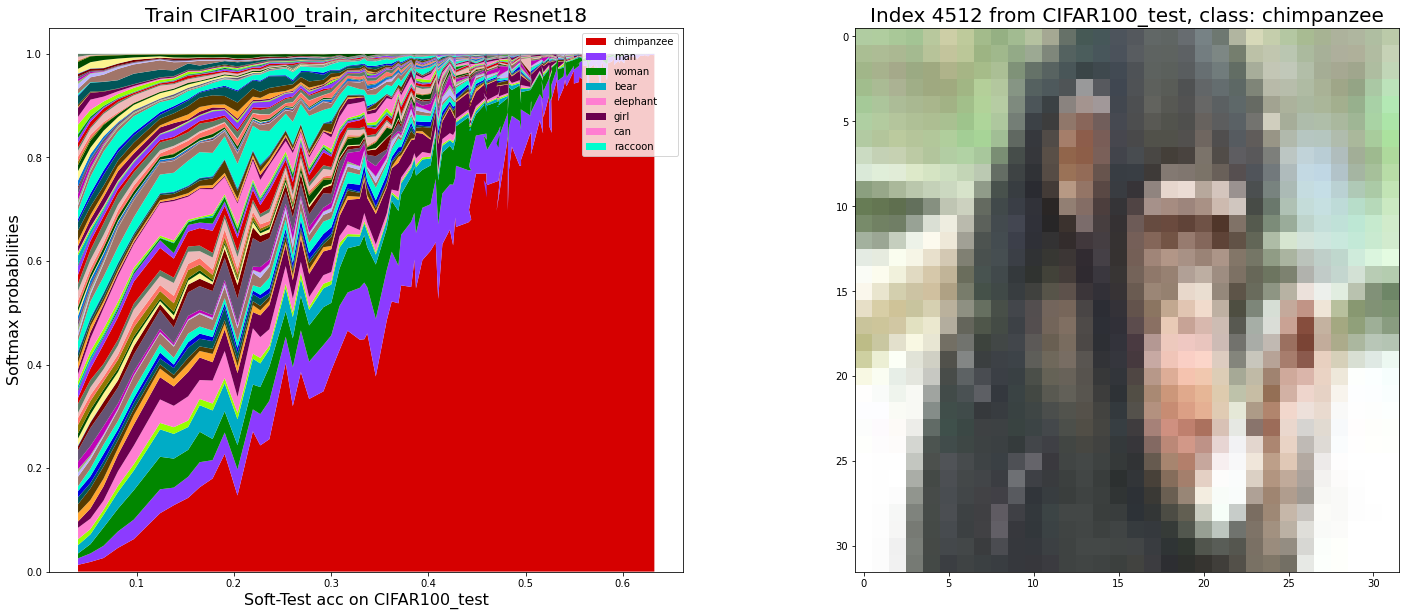

index 919
probs
Top 5 are [21  3 63 55 64]
Prediction is chimpanzee


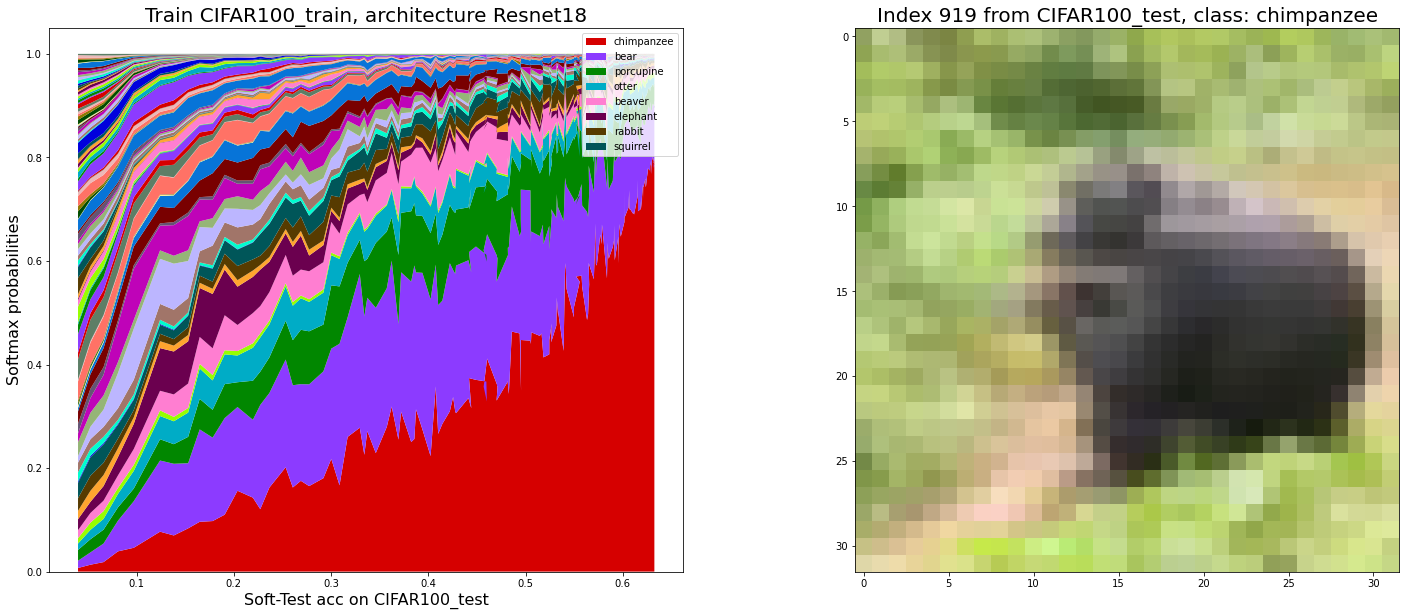

index 3348
probs
Top 5 are [61 10 22 32 83]
Prediction is plate


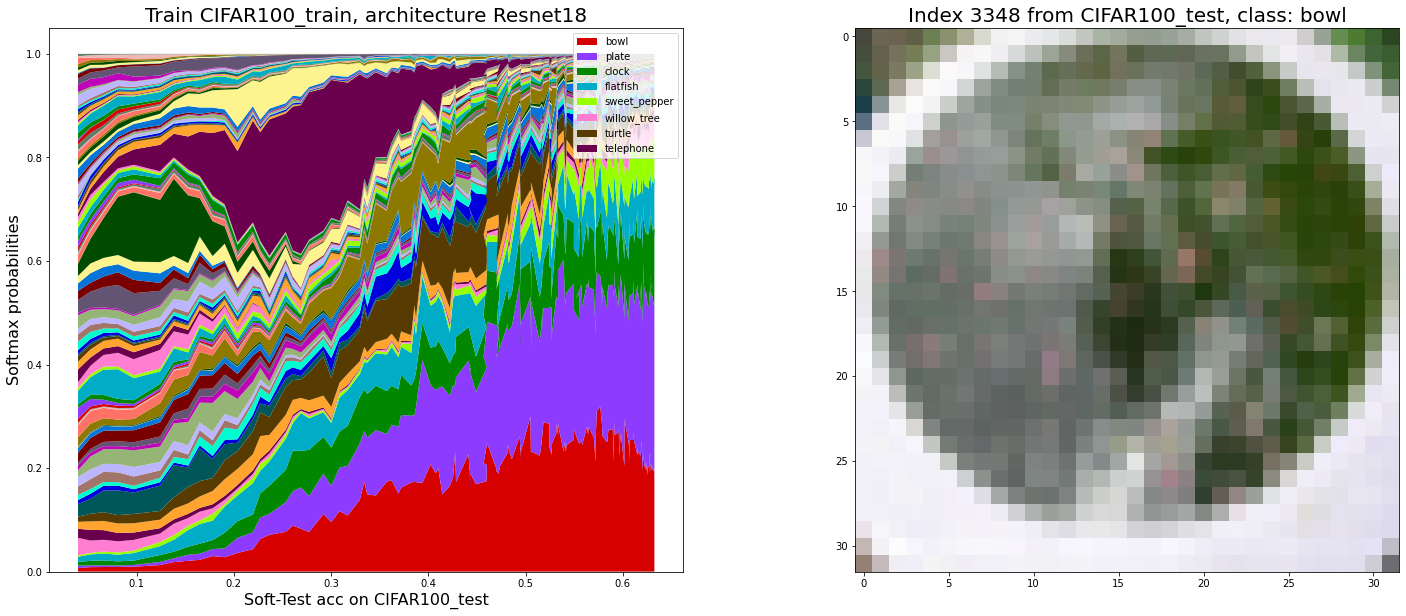

index 6001
probs
Top 5 are [18 99 69 14 44]
Prediction is caterpillar


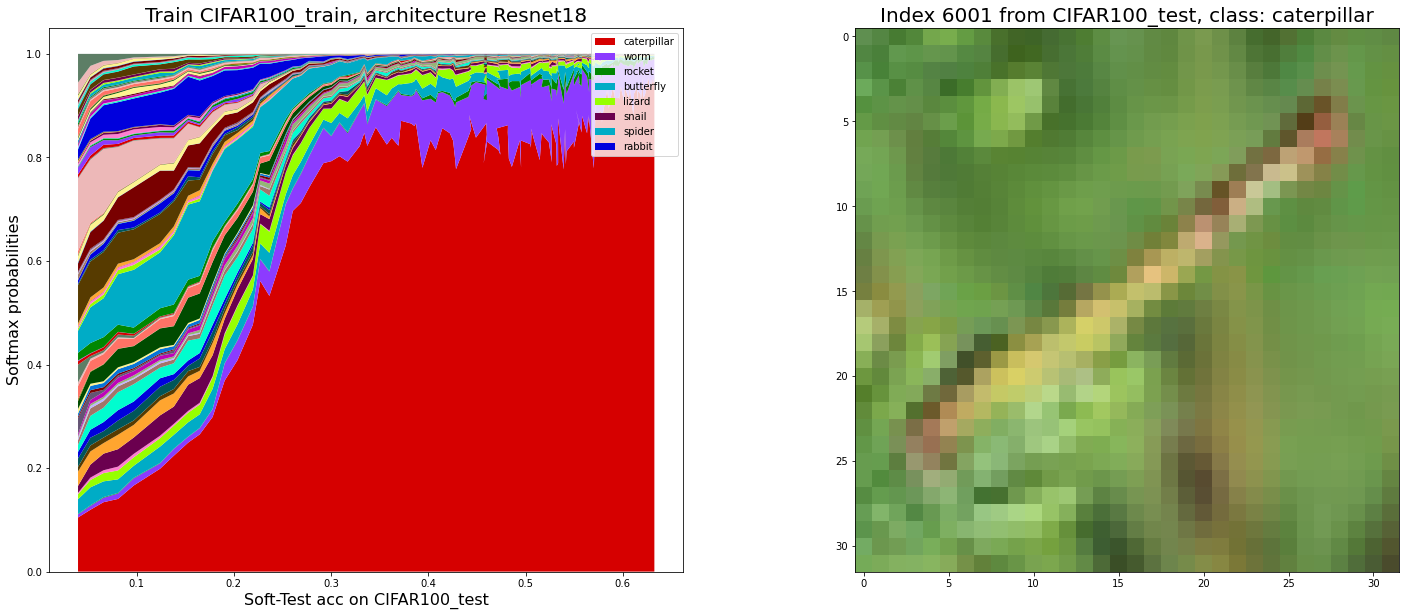

In [7]:
for idx in indices:
    stackplot(idx, types=["probs"], plot_group='Resnet18')

In [35]:
G = grouped[name][group]

def get_embed2d(index, G=grouped[name][group], t="probs", gridpts=50, height=50, topk=5):
    true_label = ytest[index]
    W, H = gridpts, height
    hh = np.linspace(0, 1, H).reshape(1, H)
    
    if t=="probs":
        x = probs_to_softacc(G["probs"])
    else:
        x = G["x"]
        
    areas = G[t][index].sum(axis=1)
    areas[true_label] = +np.infty # force true label to be first
    ind = np.argsort(areas)[::-1] # sort labels according to their integrals
    top_labels = ind

    embed = np.zeros((W, H))
    curr = np.zeros(W) # the current line
    color = 1.0 # current color [0, 1]
    xx = np.linspace(x.min(), x.max(), gridpts)
    for i, lab in enumerate(top_labels):
        # linearly interpolate the curve on uniform grid
        y = G[t][index][lab]
        f = interp1d(x, y, kind='linear')
        yy = f(xx)
        
        curr += yy
        #color = 1.0 - i/(len(top_labels)-1)
        prescale = (len(top_labels)/topk) # = 1 for including all the labels
        color = 1.0 -  prescale * i/(len(top_labels)-1)
        color = np.clip(color, 0, 1)
        
        mask = color*(hh <= curr.reshape(W, 1))
        embed = np.maximum(embed, mask)
        
    return embed

(16, 16)


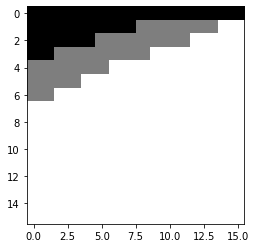

In [36]:
e = get_embed2d(np.random.randint(10000), gridpts=16,height=16, t="probs", topk=2)
print(e.shape)
plt.imshow(e.T[::-1,:], cmap='gray')

In [37]:
areas = np.array([np.mean(G["probs"][i, yi, :]) for i, yi in enumerate(ytest)])
final_accs = np.array([G["probs"][i, yi, -1] for i, yi in enumerate(ytest)])

N = 1000
INDICES = np.flatnonzero(final_accs < 0.5)[:N] # select only "hard" pts

(1000, 256)
(1000, 2)


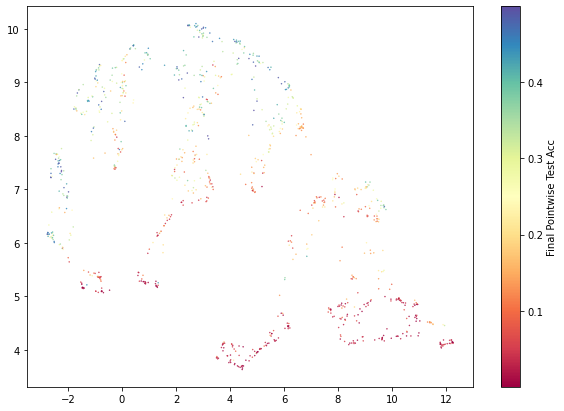

In [43]:
params = dict(
    gridpts=16,
    height=16,
    t="probs",
    topk=2
    )

X = np.array([ get_embed2d(i, **params).flatten() for i in INDICES ])
print(X.shape)

In [ ]:
Xt = umap.UMAP(min_dist=0.0, n_neighbors=15, verbose=True).fit_transform(X)
print(Xt.shape)

plt.figure(figsize=(10,7))
sc = plt.scatter(Xt[:, 0], Xt[:, 1], s=0.2, c=final_accs[INDICES], cmap='Spectral')
plt.colorbar(sc, label='Final Pointwise Test Acc')
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



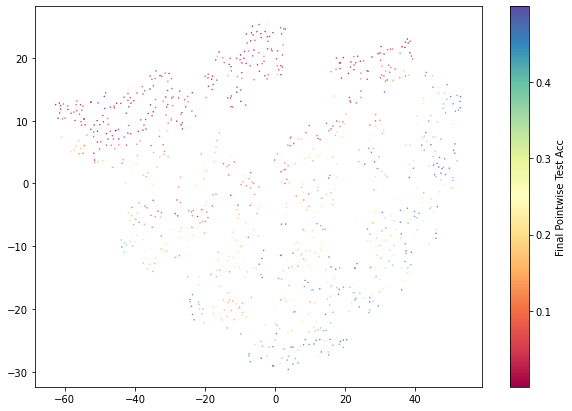

In [44]:
from sklearn.manifold import TSNE

Xt = TSNE(learning_rate='auto', init='pca', n_iter=1000, verbose=True).fit_transform(X)
final_accs = np.array([G["probs"][i, yi, -1] for i, yi in enumerate(ytest)])
fig = plt.figure(figsize=(10,7))
sc = plt.scatter(Xt[:, 0], Xt[:, 1], s=0.2, c=final_accs[INDICES], cmap='Spectral')
plt.colorbar(sc, label='Final Pointwise Test Acc')
plt.show()

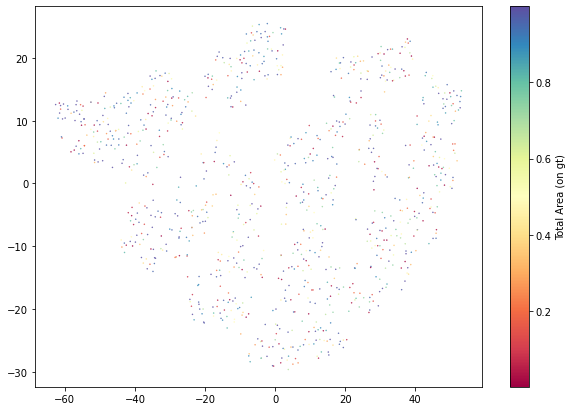

In [45]:
fig = plt.figure(figsize=(10,7))

sc = plt.scatter(Xt[:, 0], Xt[:, 1], s=0.2, c=areas[:N], cmap='Spectral')
plt.colorbar(sc, label='Total Area (on gt)')
plt.show()

In [46]:
import plotly.graph_objs as go
import plotly.express as px

df = pd.DataFrame(Xt, columns=('x', 'y'))
df['class'] = [classes[ytest[i]] for i in INDICES]
df['final_acc'] = final_accs[INDICES]

n = 1000
fig = go.FigureWidget(
    data=[
        dict(
            type='scattergl',
            x=Xt[:n, 0],
            y=Xt[:n, 1],
            marker=dict(color=final_accs[INDICES][:n], colorscale='Spectral'),
#             marker=dict(color=[ytest[i] for i in INDICES]),
            text=df['class'][:n],
            mode='markers'
        )
    ],
)
fig.update_layout(
    autosize=False,
    width=800,
    height=600)
fig

FigureWidget({
    'data': [{'marker': {'color': array([0.03704412, 0.028883  , 0.02113393, ..., 0.08739233, 0…

In [47]:
from ipywidgets import Image, HTML, VBox, HBox, Output
from IPython.display import display, clear_output
import PIL
from io import BytesIO
import PIL.Image

def tobytes(a, fmt='png'):
    a = np.uint8(a)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    return f.getvalue()

def np_to_bytes(a, fmt='png'):
    a = np.uint8(a)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    return f.getvalue()



def singlestack(fig, index, t = "probs", plot_group = "Resnet18"):
    ax1, ax2 = fig.axes
    
    
    dct = grouped[name][plot_group]
#     print("index %d" % index)
    img, label = dataset.__getitem__(index)
    img = np.array(img)
    col = sns.color_palette(cc.glasbey, n_colors=25)

        
    y = dct[t][index].copy() # probs/freqs

    ind = np.argsort(y[:,-1])[::-1] # sort labels according to their final probabilities
    #         print(f"Top 5 are {ind[:5]}")
    #         print(f"Prediction is {classes[ind[0]]}")
    y = y[ind]
    labels = [classes[ind[i]] for i in range(len(classes))]
    new_label = list(ind).index(label)

    # swap in the true-label as the first label in list (and in y)
    labels[0], labels[new_label] = labels[new_label], labels[0]
    y[[0,new_label]] = y[[new_label,0]]
    labels = cut_labels(y, labels)

    if t=="probs":
        xx = probs_to_softacc(dct["probs"])
        ax1.set_xlabel("Soft-Test acc on %s" % name, fontsize=16)
        ax1.set_ylabel("Softmax probabilities", fontsize=16)

    else:
        xx = dct["x"]
        ax1.set_xlabel("Test acc on %s" % name, fontsize=16)
        ax1.set_ylabel("Frequency of predictions", fontsize=16)


    ax1.stackplot(xx, y, labels=labels, colors = col)
    ax1.set_title(
        "Train %s, architecture %s" % (train_set, plot_group),
        fontsize=20,
    )

    ax1.legend(loc="best")
    ax2.imshow(img, interpolation="nearest")
    ax2.set_title("Index %d from %s, class: %s" % (index, name, classes[label]), fontsize=20)
        

    
image_widget = Image(value=tobytes(dataset[0][0]), height=64, width=64)
im2 = Image(value=tobytes(X[0].reshape(GRIDPTS, HEIGHT).T[::-1, :]*255), height=HEIGHT*4, width=GRIDPTS*4)

ind = 0

def hover_fn(trace, points, state):
    # Update image widget
    ind = points.point_inds[0]
    # print(ind)
    image_widget.value = tobytes(dataset[INDICES[ind]][0])
    
    im2.value = tobytes(X[ind].reshape(GRIDPTS, HEIGHT).T[::-1, :]*255)

    

    
scatter = fig.data[0]
scatter.on_hover(hover_fn)

VBox([fig, HBox([image_widget, im2])])

    'data': [{'marker': {'color': array([0.03704412, 0.028883  , 0.02113393, ...…